# CREAM Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH SSDs
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 20GB DDR4 (may need 80GB for full dataset evaluation)

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* Dataset size: `39.565648284999995` GB (`X8/du -bh .` / 1000 / 1000 / 1000)
* Amount of `.hdf5` files (total hours): `744` (`find . -name "*.hdf5' | wc -l`)
* Amount of days: `47` (`ls -la | grep 2018 | wc -l`)
* Avg. filesize: `53.17963479166666` MB (dataset size / filecount)
* 1h in each file, each sample is 10s: `0.1477212077546296` MB (avg. filesize / 60 / 6)
* Sample sizes (rounded to second decimal):
    * `0500:      73.86 MB` 
    * `1000:     147.72 MB`
    * `2000:     295.44 MB`
    * `4000:     590.88 MB`
    * `8000:    1181.77 MB`
    * `267840: 39565.65 MB`

## General Dataset Information

In [1]:
cream_mains_frequency_hz = 50
cream_sps = 6400
cream_period_length = cream_sps / cream_mains_frequency_hz
print(f"Cream period: {int(cream_period_length)}")
total_hours = 744
window_size_s = 10 # taken from MEED
print(f"Window Size: {window_size_s}s")
windows_per_hour = (60 * 60) / window_size_s
# float64 = 8 byte, voltage + current = "*2"
raw_data_size_per_hour_mb = windows_per_hour * window_size_s * cream_sps * 8 * 2 / 1000 / 1000
print(f"Data per hour: {raw_data_size_per_hour_mb}MB")
samples_per_hour = cream_sps * 60 * 60
print(f"Samples per hour: {samples_per_hour}")
samples_per_window_size = cream_sps * window_size_s
print(f"Samples per windowsize: {samples_per_window_size}")
full_dataset_windowcount = total_hours * windows_per_hour
print(f"Windows Total: {int(full_dataset_windowcount)}")

for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_windowcount * 100, 2)}%")

Cream period: 128
Window Size: 10s
Data per hour: 368.64MB
Samples per hour: 23040000
Samples per windowsize: 64000
Windows Total: 267840
500 of total: 0.19%
1000 of total: 0.37%
2000 of total: 0.75%
4000 of total: 1.49%
8000 of total: 2.99%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')

from notebookhelper import show_values_on_bars, save_figure

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [8]:
local_fig_dir = "cream-pipeline"
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

    
home_path = "../logs/cream"
path_to_cum_df = f"{home_path}/cream_2021-03-18-01:37:42_cum-df_samples-500-1000-2000-4000-8000-267840_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/cream_2021-03-18-01:37:42_cum-dstat-df_samples-500-1000-2000-4000-8000-267840_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()

# we forgot to remove the "list-files" step from the profiling, so we do it in this log processing
cum_df = cum_df.query("split_name!='1-list-files'")
cum_dstat_df = cum_dstat_df.query("split_name!='1-list-files'")
summary      = analysis.summary().query("strategy!='1-list-files'")
strategies   = summary.strategy.unique()
strategies_renamed = ["unprocessed", "v/c-extraction", "full"] #"phased-processing"]
print(strategies)

['0-fully-online' '2-voltage-+-current-extraction-6.4khz'
 '3-active-power-+-rms-current-+-cumsum-rms-current']


In [4]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp
0,0.000000,8,8,0.0000,500,50.515477,9.897957,0,1,ab7415,0-fully-online,2021-04-01-14:31:56
2,27.790490,8,8,512.0300,500,12.440870,40.190117,0,1,9fa81b,2-voltage-+-current-extraction-6.4khz,2021-04-01-14:31:56
3,36.784242,8,8,6.0285,500,0.189181,2642.973628,0,1,618d33,3-active-power-+-rms-current-+-cumsum-rms-current,2021-04-01-14:31:56
4,0.000000,8,8,0.0000,1000,51.926557,19.257969,0,1,2ec08c,0-fully-online,2021-04-01-14:35:11
6,30.635357,8,8,1024.0600,1000,24.802321,40.318807,0,1,bb7101,2-voltage-+-current-extraction-6.4khz,2021-04-01-14:35:11


In [5]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,split_name,creation_timestamp
0,0.0,0.007850,0.003666,0.000000,0.000000,0,500,8,8,ab7415,0-fully-online,2021-04-01-14:31:56
1,1.0,12.619776,0.000000,52.861662,0.125908,0,500,8,8,ab7415,0-fully-online,2021-04-01-14:31:56
2,2.0,1.249280,3.579904,160.221863,0.356410,0,500,8,8,ab7415,0-fully-online,2021-04-01-14:31:56
3,3.0,0.020480,0.000000,70.846309,0.124030,0,500,8,8,ab7415,0-fully-online,2021-04-01-14:31:56
4,4.0,0.000000,0.000000,37.083871,0.078597,0,500,8,8,ab7415,0-fully-online,2021-04-01-14:31:56


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a strategy (e.g., `0-fully-online`) with a certain sample count (e.g, `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`.

`norm_thread_experiment_count` should be `5` for all.

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [6]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]

for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count}'))
    for thread_count in cum_df.query(f'sample_count=={sample_count}')['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)
        add_to_dict(sample_count, sample_experiment_count,
                    thread_count, thread_experiment_count, norm_thread_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count
0,500,60,8,15,5.0
1,500,60,1,15,5.0
2,500,60,2,15,5.0
3,500,60,4,15,5.0
4,1000,60,8,15,5.0
5,1000,60,1,15,5.0
6,1000,60,2,15,5.0
7,1000,60,4,15,5.0
8,2000,60,8,15,5.0
9,2000,60,1,15,5.0


# 1. Storage Consumption Analysis

## 1.1 Uncompressed dataset storage consumption compared the different strategies

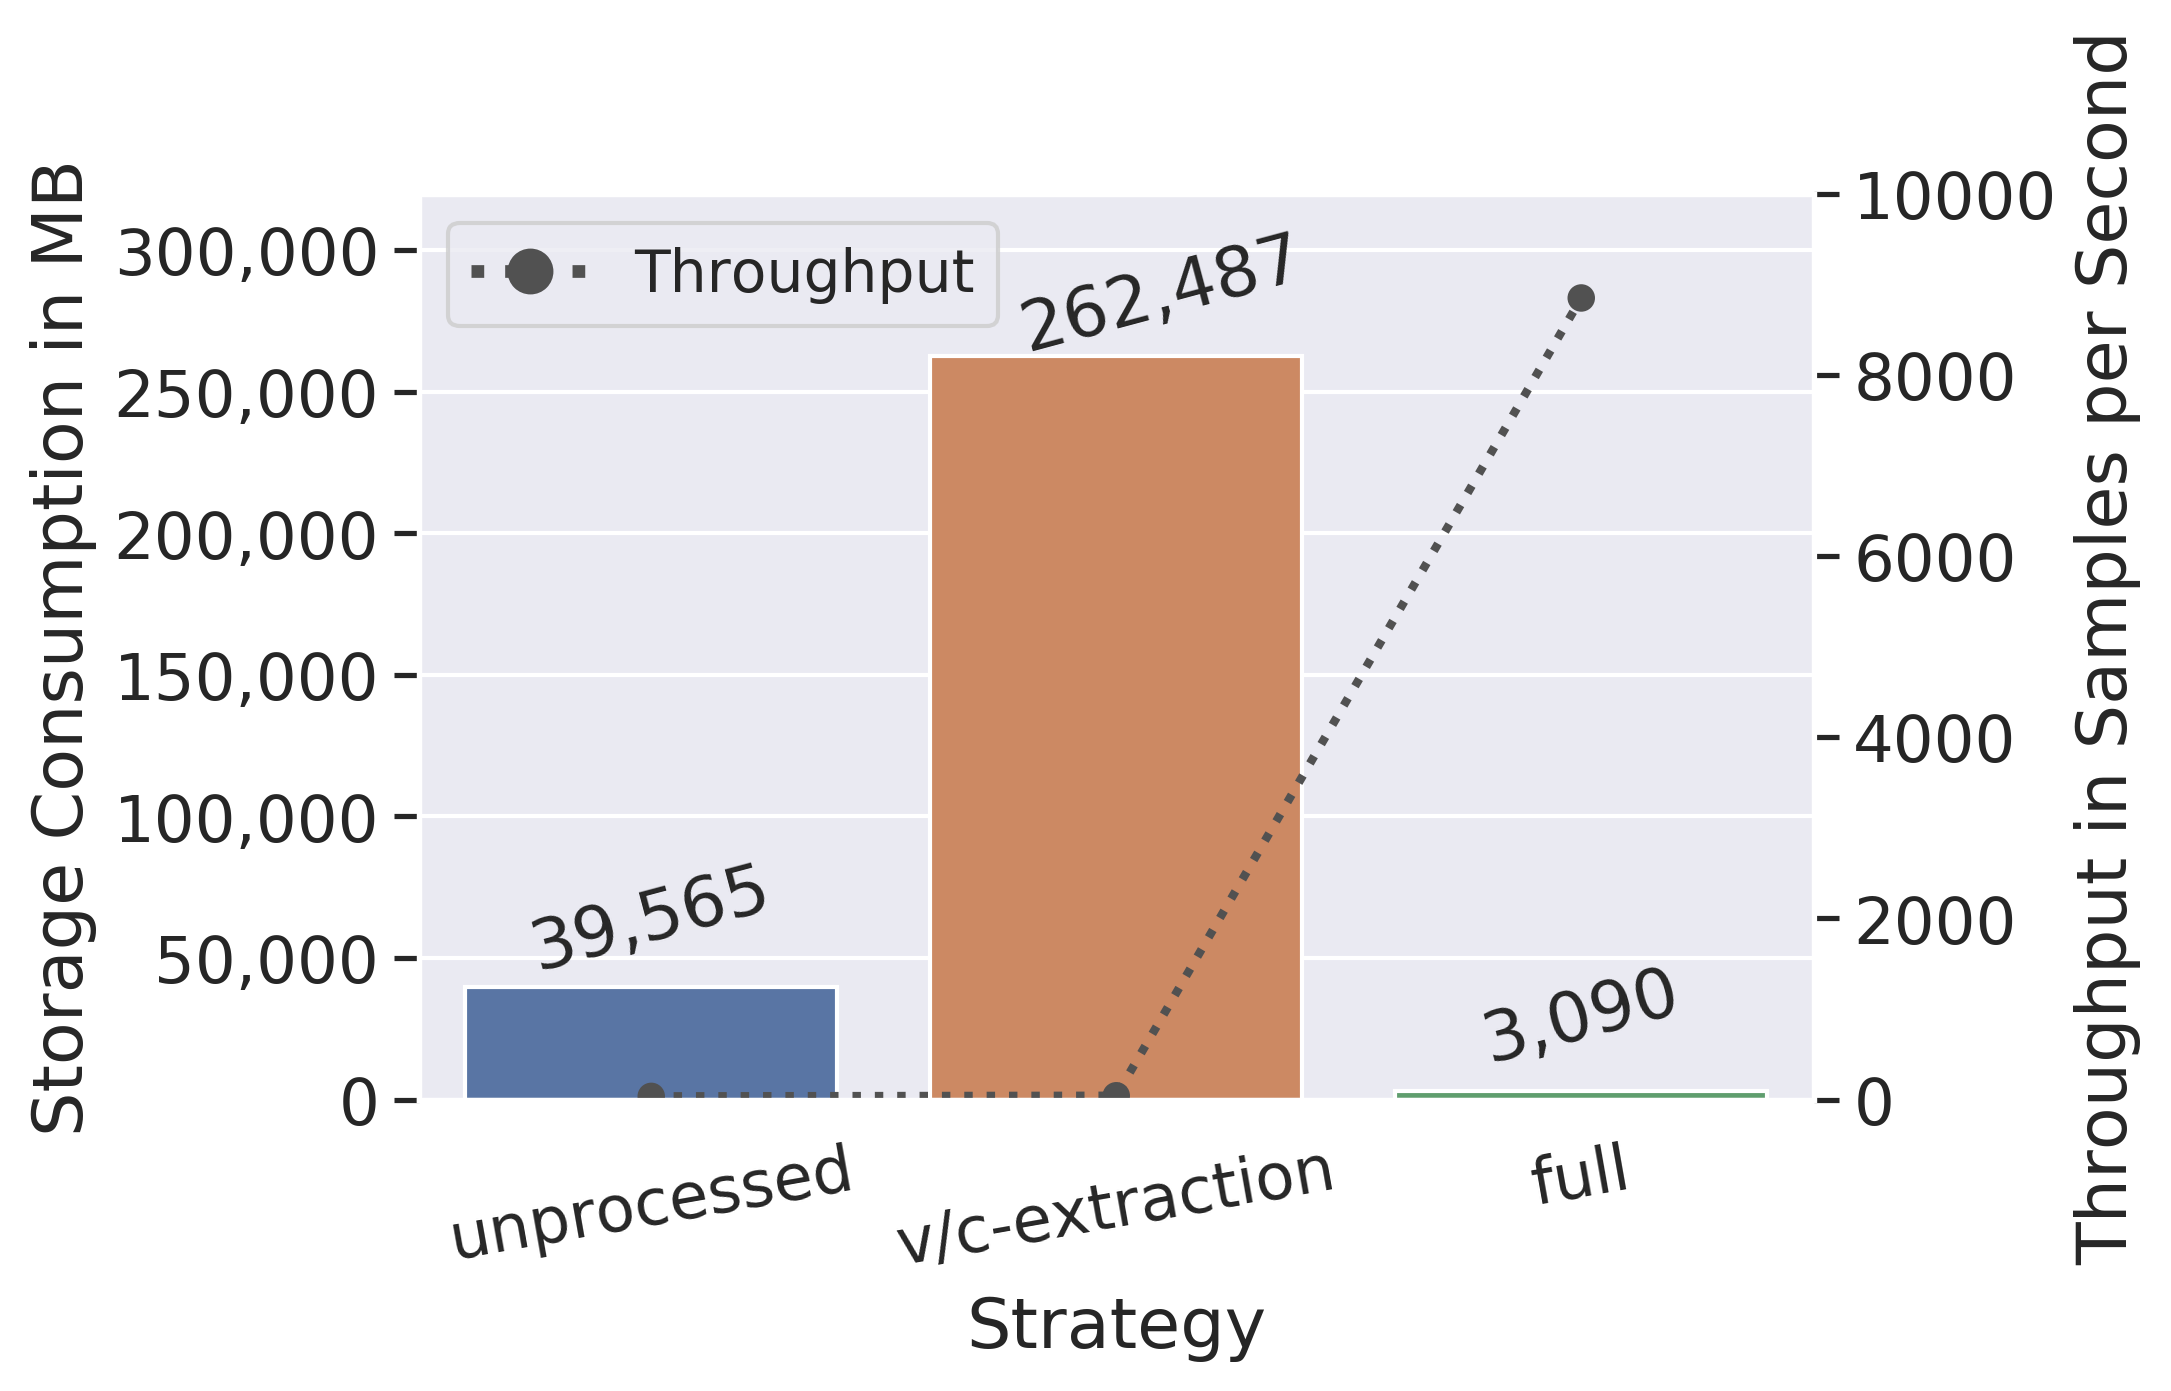

In [9]:
sample_size_mb_dict = {
    "500": 74.14
  , "1000": 148.28
  , "2000": 296.57
  , "4000": 593.13
  , "8000": 1186.26
  , "267840": 39565.65
}

storage_consumption_comparison = {
    "storage_consumption": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.set(font_scale=1.4)

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps",
                    data=cum_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
                    ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples per Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=10, color=throughput_color, lw=3.05, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 14})
plot2.set(ylim=(0, 10000))          


plot = sns.barplot(
        x="strategy",
        y="storage_consumption",
        data=storage_df.query(f"sample_count=={np.max(cum_df.sample_count.unique())}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
show_values_on_bars(plot, h_v="v", space=28000, rotation=15, additional_x_space=[0, 0.1, 0])
plot.set(ylabel="Storage Consumption in MB", xlabel="Strategy")
plot.set(ylim=(0, 320000))

# FuncFormatter can be used as a decorator
@ticker.FuncFormatter
def major_formatter(value, pos):
    return re.sub(r'(?<!^)(?=(\d{3})+$)', r',', str(value)[0:-2])

plot.yaxis.set_major_formatter(major_formatter)
save_fig("storage-consumption")

# 2. Preprocessing Time Analysis

## 2.1 Preprocessing Time Plots

[(0, 300)]

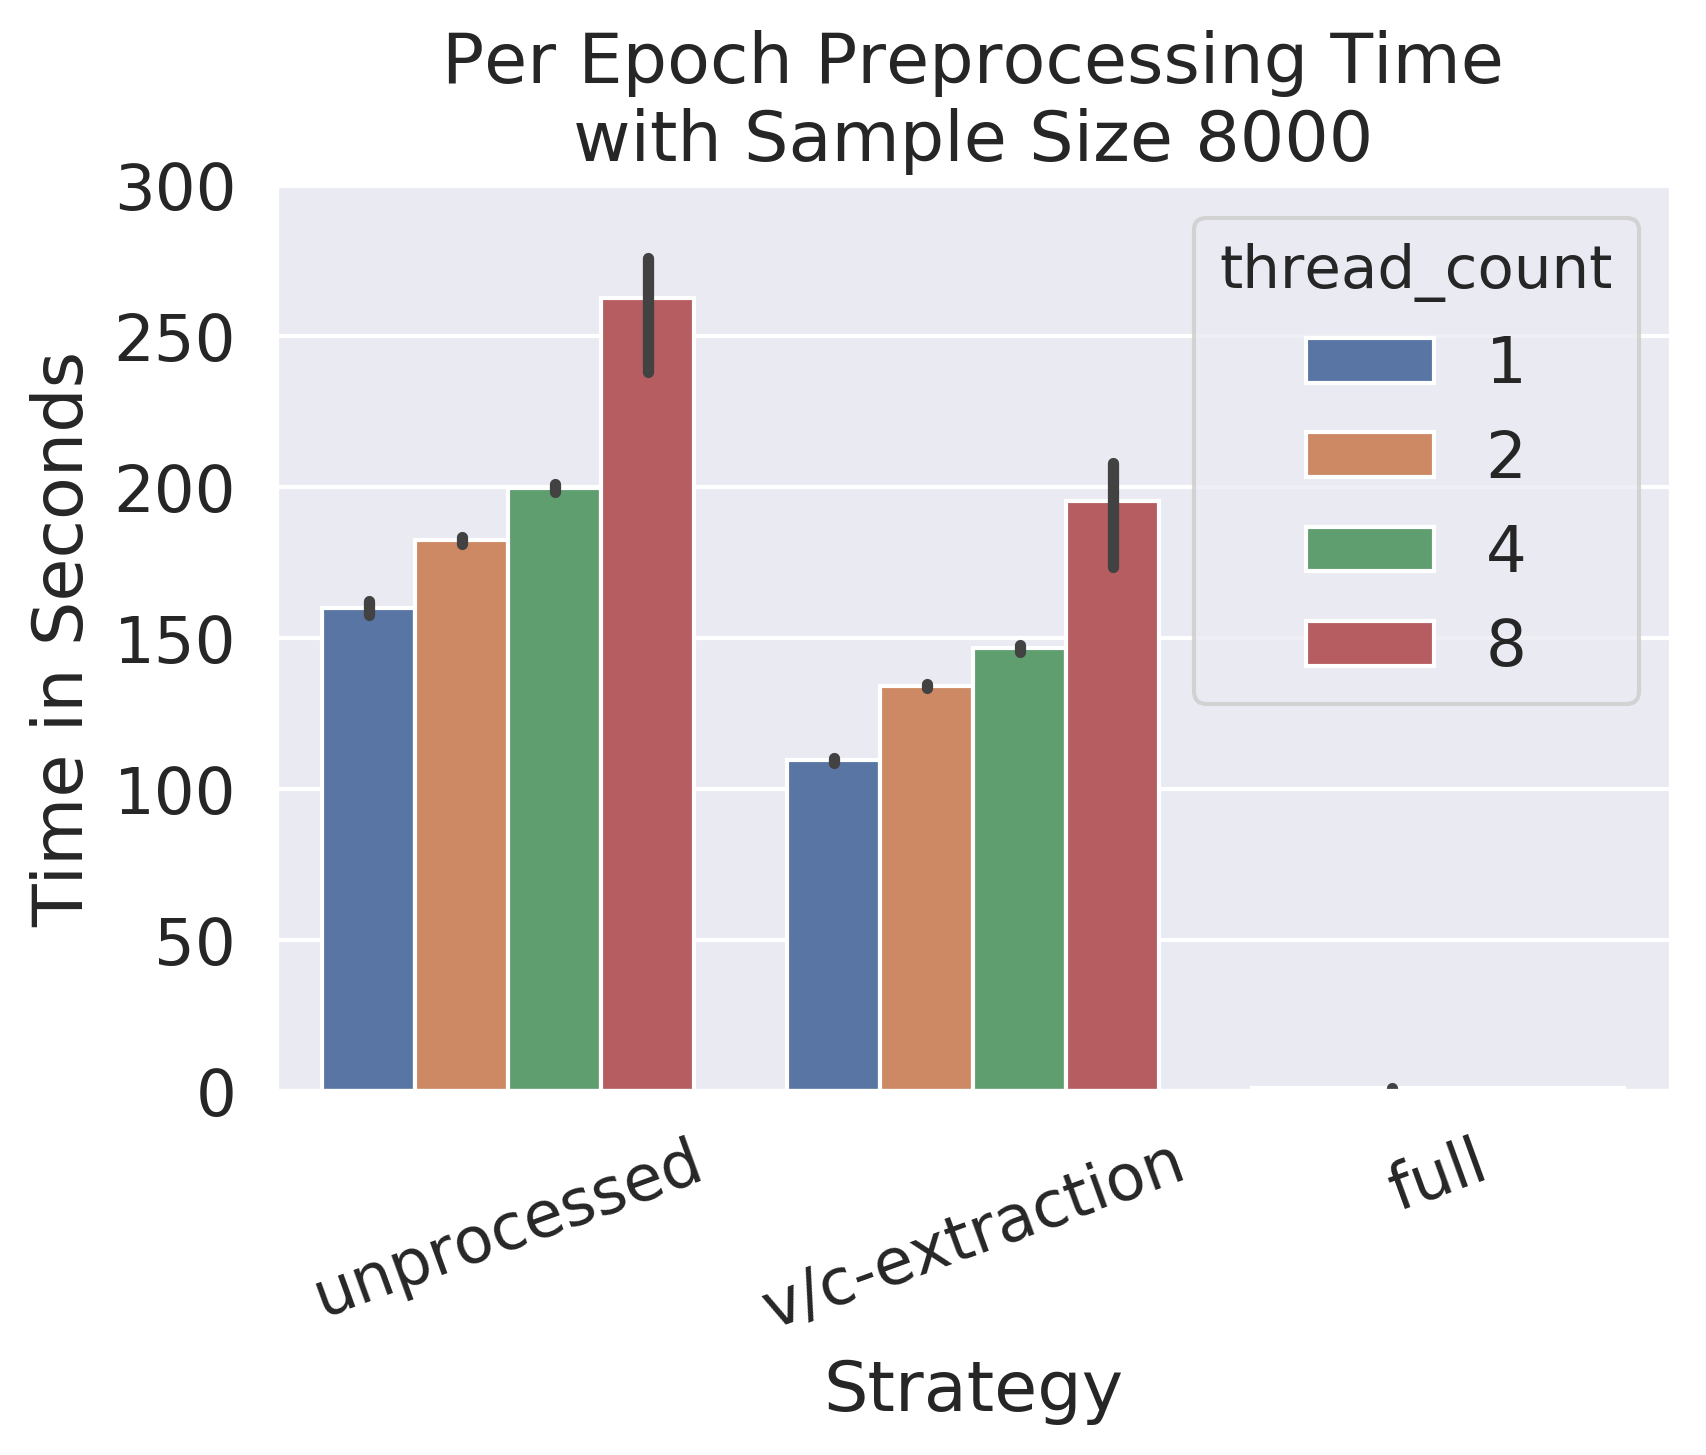

In [10]:
plot = sns.barplot(
    x="split_name",
    y="online_processing_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Per Epoch Preprocessing Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 300))

[(0, 300)]

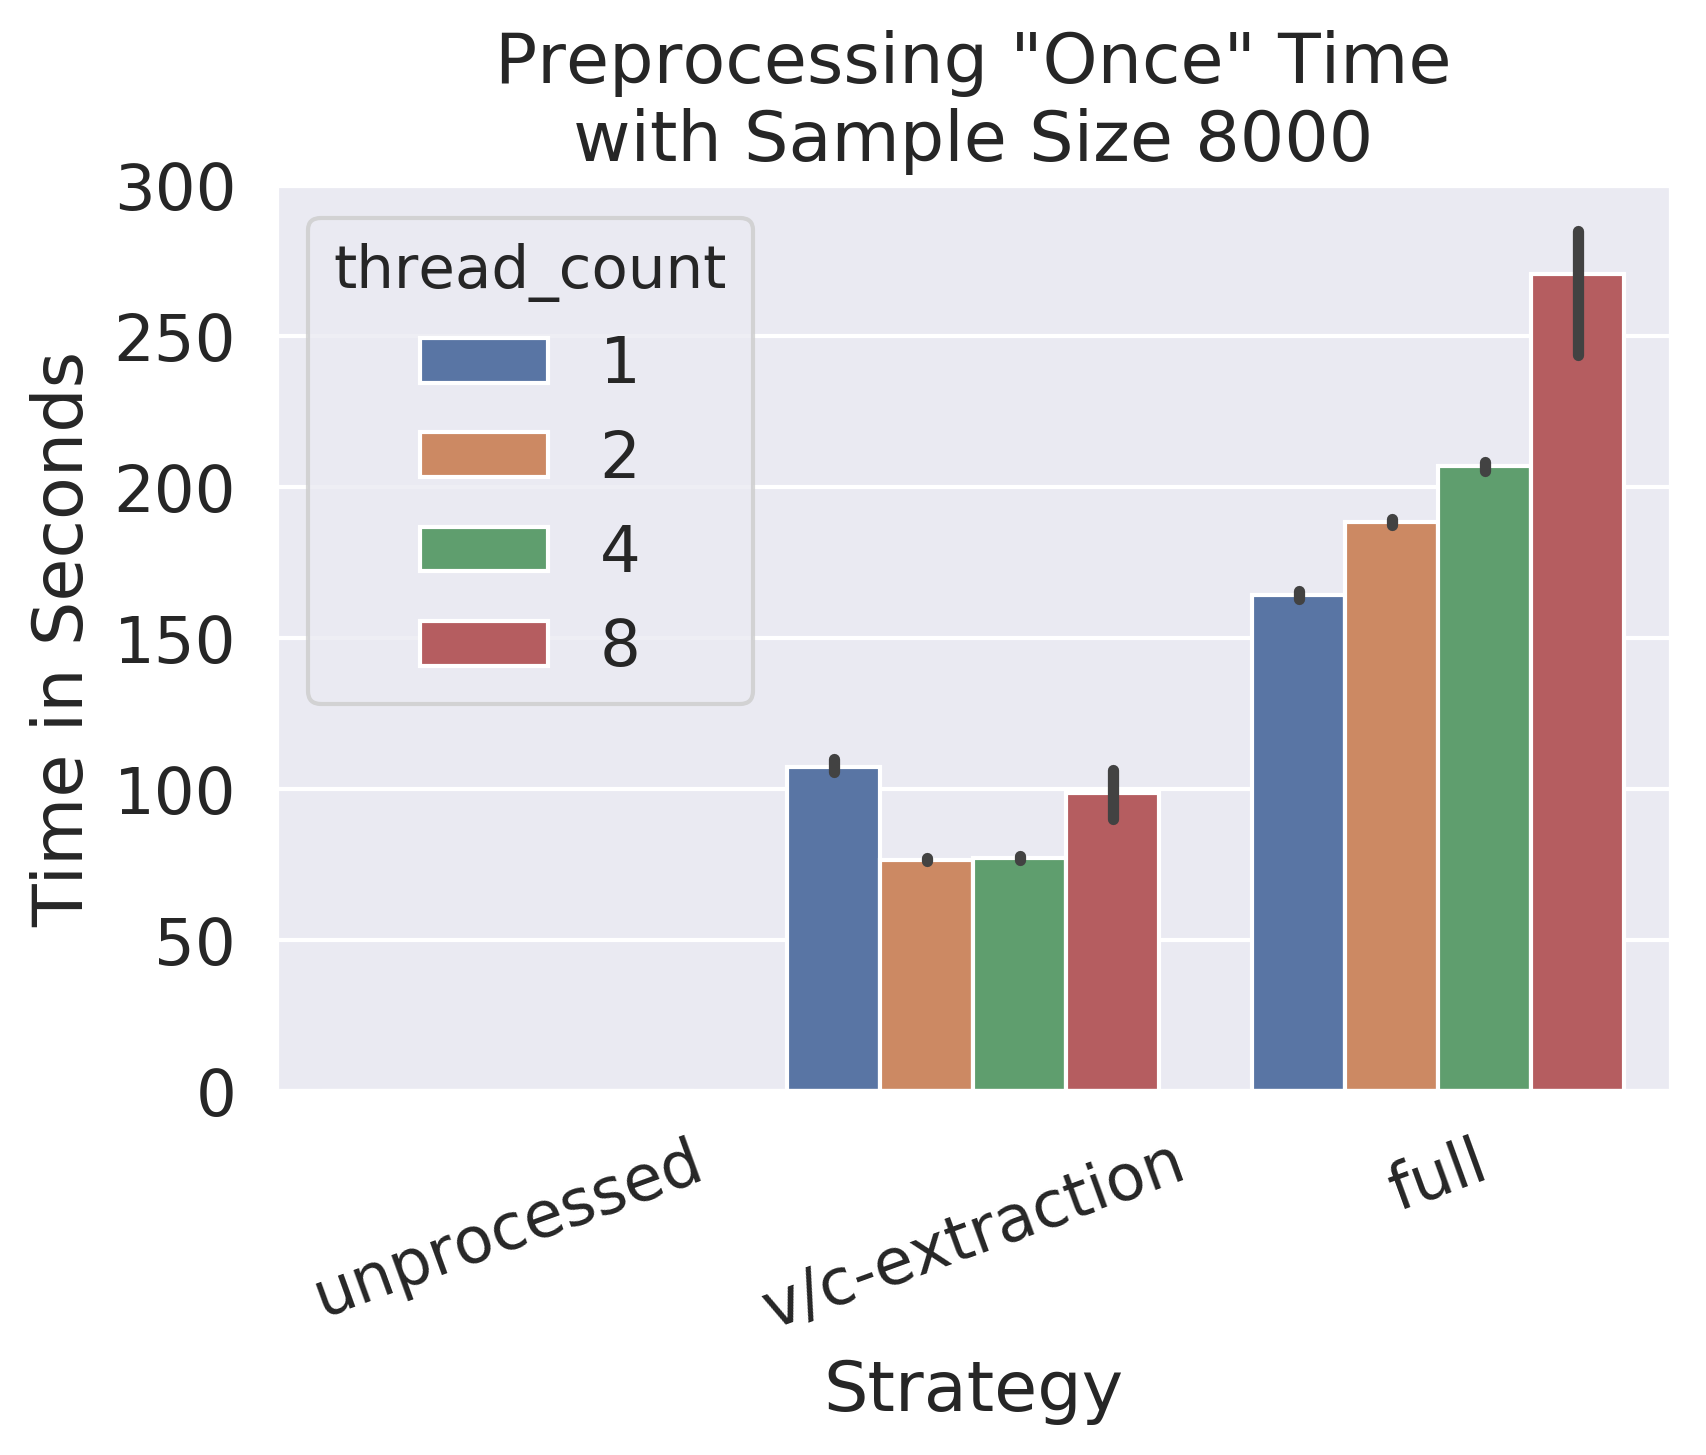

In [12]:
plot = sns.barplot(
    x="split_name",
    y="offline_processing_and_save_time_s",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Preprocessing \"Once\" Time\n with Sample Size 8000 {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Seconds")
plot.set(ylim=(0, 300))

## 2.2 Unmarshalling Cost for Last Data Representation

[Text(0, 0.5, 'Time in Seconds'), Text(0.5, 0, 'Sample Count')]

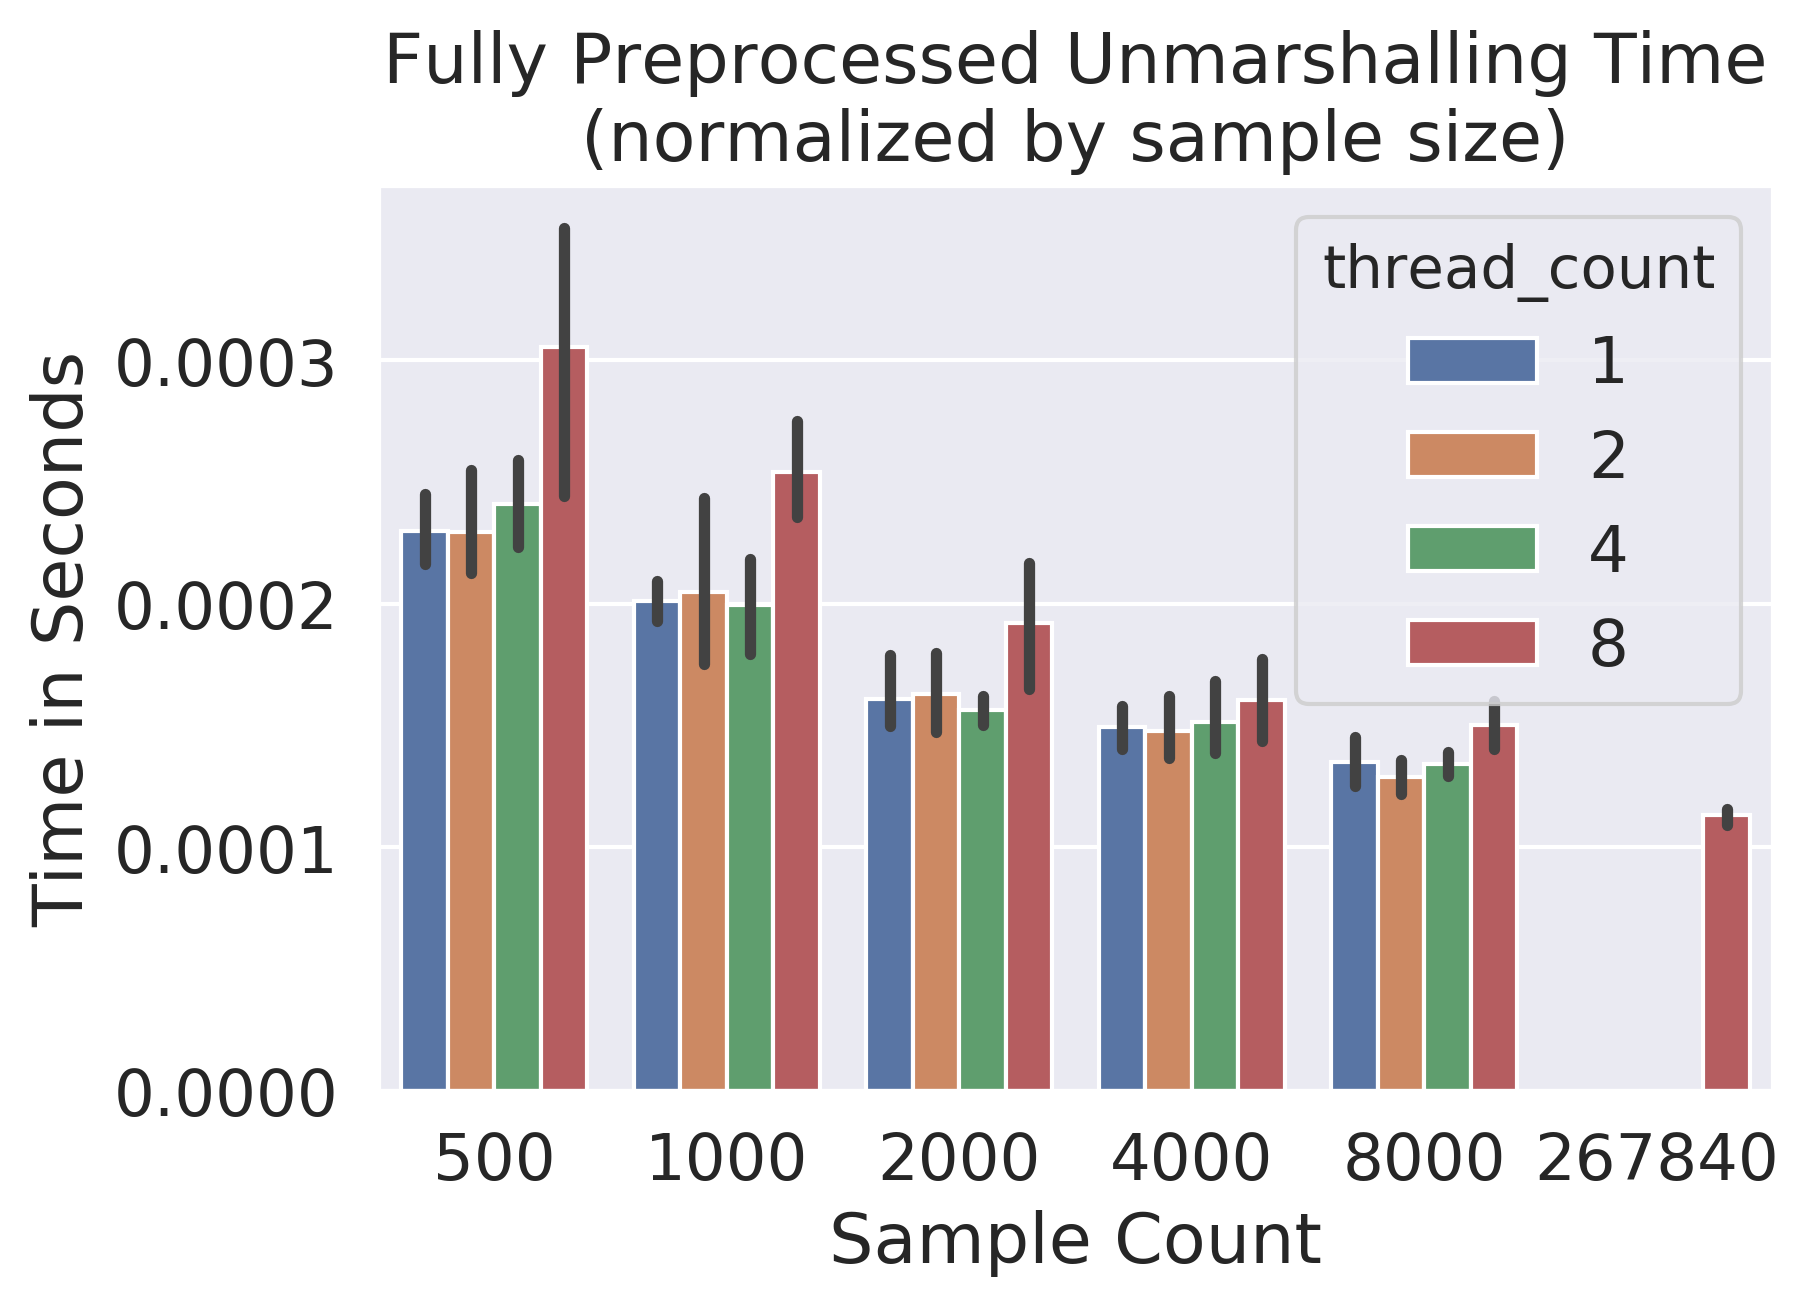

In [13]:
test_df = cum_df.copy(deep=True)
test_df["normalized_online_processing_time_s"] = test_df["online_processing_time_s"] / test_df["sample_count"]

plot = sns.barplot(
    x="sample_count",
    y="normalized_online_processing_time_s",
    hue="thread_count",
    data=test_df.query(f"split_name=='{strategies[-1]}'")
)
plot.set_title(f"Fully Preprocessed Unmarshalling Time\n(normalized by sample size){sampling_tag}")
plot.set(xlabel="Sample Count", ylabel="Time in Seconds")
#plot.set(ylim=(0,1.4))

# 3. Throughput Analysis

## 3.1 Throughput (sample_count = 8000)

[(0, 10000)]

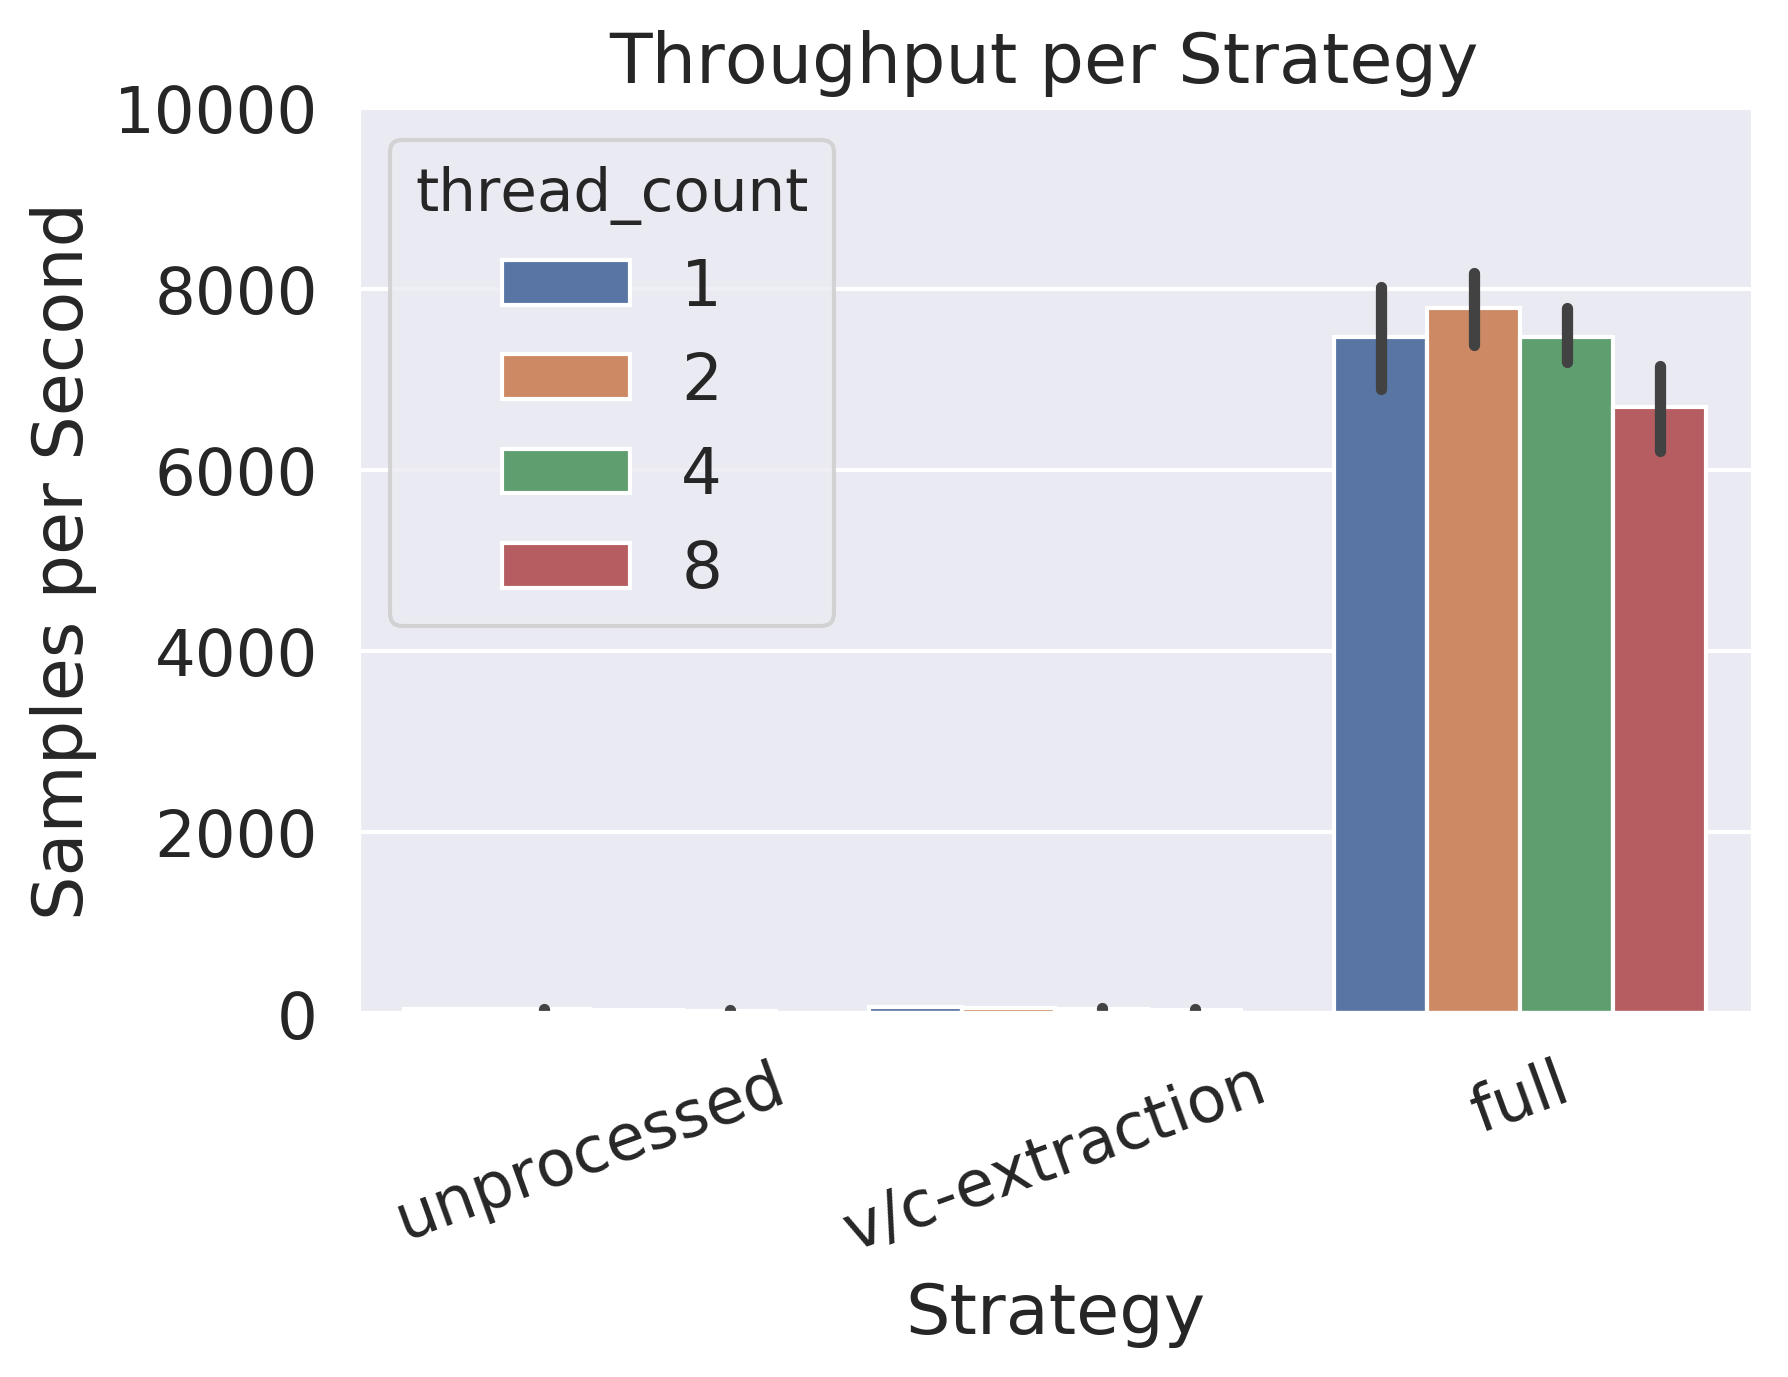

In [14]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="thread_count",
    data=cum_df.query(f"sample_count==8000")
)
plot.set_title(f"Throughput per Strategy {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Samples per Second")
plot.set(ylim=(0, 10000))

## 3.2 Parallelization capabilities (sample_count = 8000)

In [16]:
cum_8000_df = cum_df.query("sample_count==8000")

par_capability = {
      "threads": []
    , "strategy": []
    , "speedup": []
}

def add_capability(threads, strategy, speedup):
    par_capability["threads"] += [threads]
    par_capability["strategy"] += [strategy]
    par_capability["speedup"] += [speedup]

for strategy in strategies:
    for thread_count in cum_df.thread_count.unique():
        throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}'")["throughput_sps"].to_numpy()
        for throughput in throughputs:
            avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}'")["throughput_sps"].mean()
            # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
            #if avg_step_t1_throughput < throughput:
            #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
            #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
            #else:
            #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
            #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
            ## now using speedup instead of increase/decrease factor
            speedup = throughput / avg_step_t1_throughput
            add_capability(thread_count, strategy, speedup)

capability_df = pd.DataFrame(par_capability)
capability_df

,threads,strategy,speedup
0,8,0-fully-online,0.579358
1,8,0-fully-online,0.581110
2,8,0-fully-online,0.586311
3,8,0-fully-online,0.581417
4,8,0-fully-online,0.749108
5,1,0-fully-online,0.981293
6,1,0-fully-online,0.982941
7,1,0-fully-online,1.029312
8,1,0-fully-online,1.009167
9,1,0-fully-online,0.997287


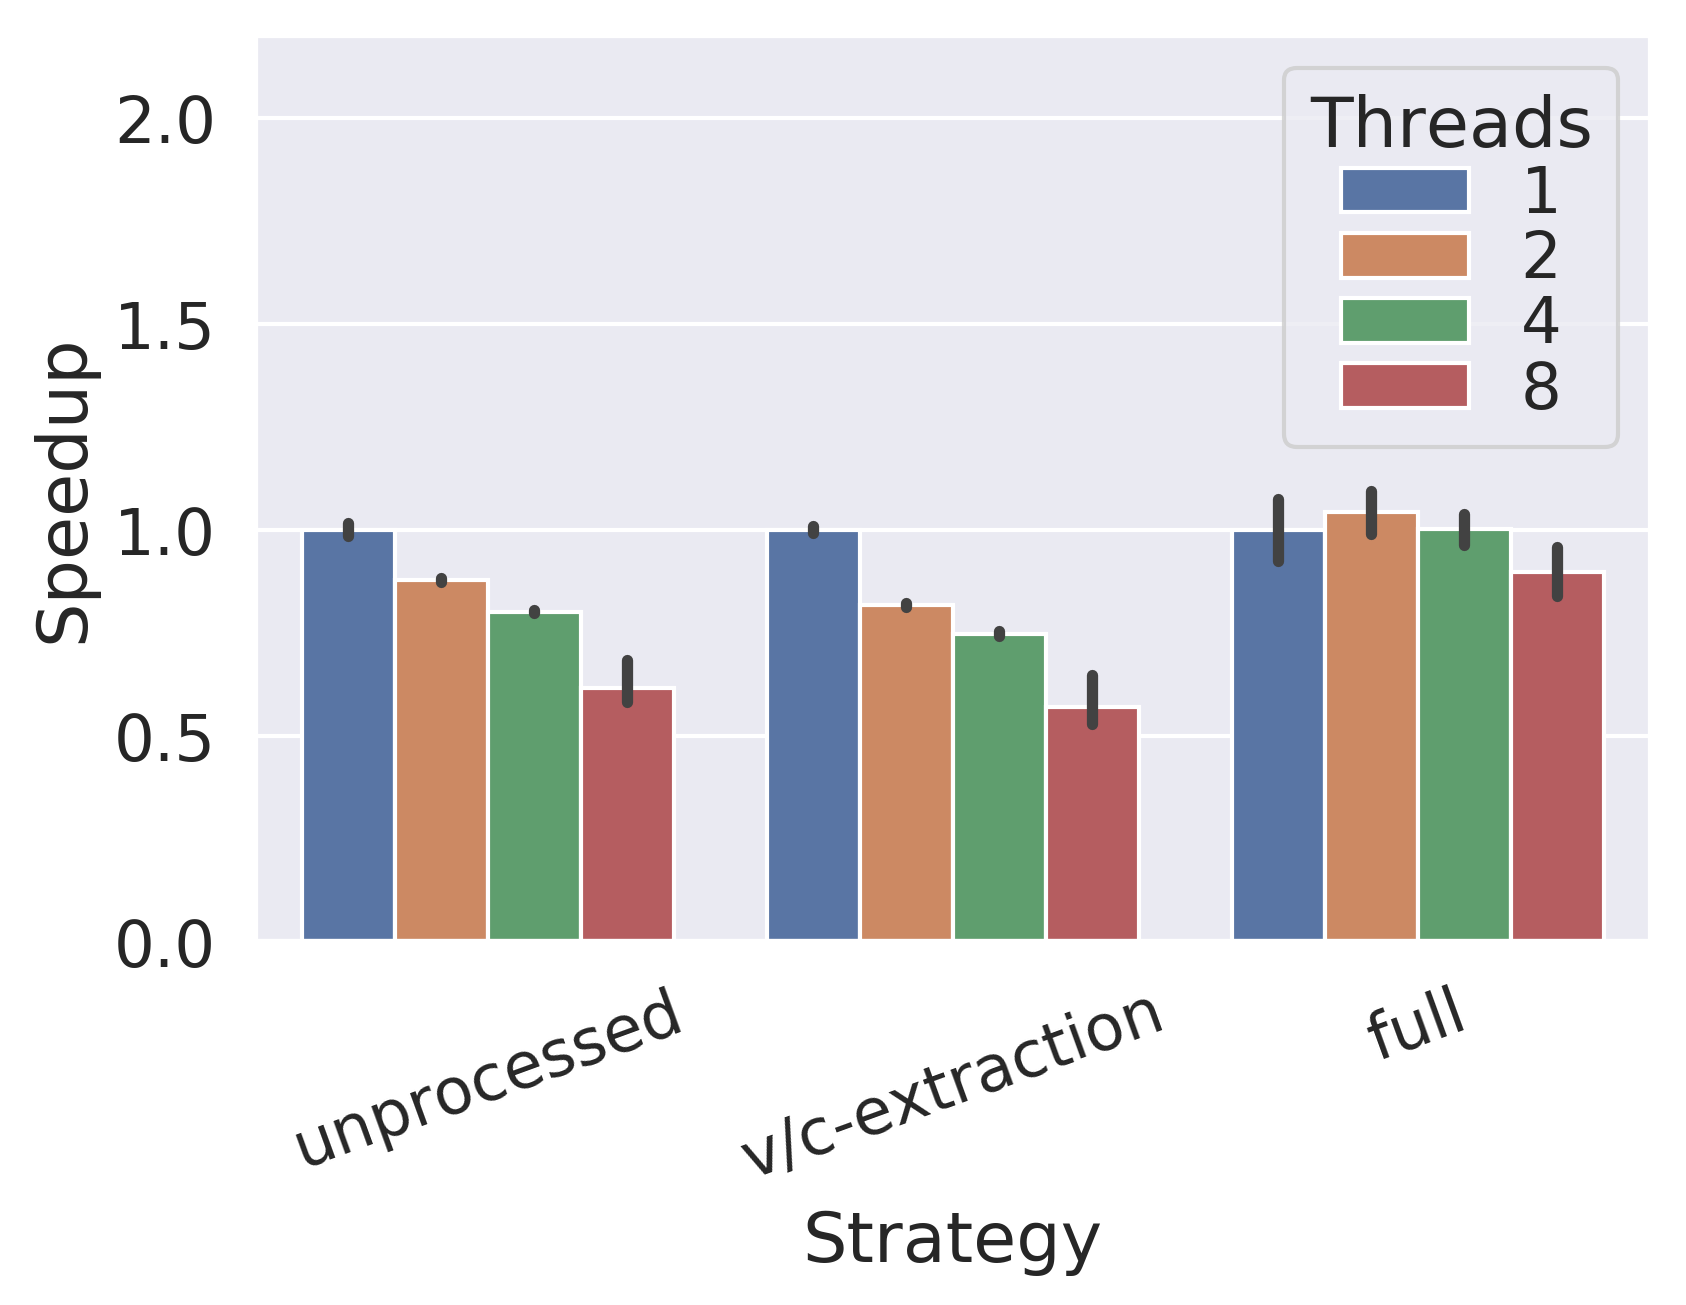

In [17]:
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="threads",
    data=capability_df
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
#plot.set_title(f"Speedup for Each Strategy Compared to\n Average Single Threaded Throughput\n with a Sample Size 8000")
plot.set(xlabel="Strategy", ylabel="Speedup")
plot.set(ylim=(0, 2.2))
plot.legend(title="Threads", ncol=1,labelspacing=0.05)
save_fig("speedup")

## 4. Extrapolation Capabilities

In [18]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]

# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_windowcount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_windowcount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60

# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60 
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 

cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 267840, 'sample_count'] = '268K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '268K (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))
cum_df_mod

/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,...,per_sample_online_processing_time_s,per_sample_offline_processing_and_save_time_s,total_processing_time_s,full_dataset_online_processing_time_s,full_dataset_offline_processing_and_save_time_s,full_dataset_offline_processing_and_save_time_m,full_dataset_offline_processing_and_save_time_h,full_dataset_processing_time_s,full_dataset_processing_time_m,full_dataset_processing_time_h
0,0.000000,8,8,0.00000,500,50.515477,9.897957,0,1,ab7415,...,0.101031,0.000000,50.515477,27060.130944,0.000000,0.000000,0.000000,27060.130944,451.002182,7.516703
16,0.000000,8,8,0.00000,500,38.800188,12.886535,0,1,0b568d,...,0.077600,0.000000,38.800188,20784.484742,0.000000,0.000000,0.000000,20784.484742,346.408079,5.773468
32,0.000000,8,8,0.00000,500,38.657614,12.934062,0,1,5a2317,...,0.077315,0.000000,38.657614,20708.110919,0.000000,0.000000,0.000000,20708.110919,345.135182,5.752253
48,0.000000,8,8,0.00000,500,39.488837,12.661806,0,1,7223b3,...,0.078978,0.000000,39.488837,21153.380206,0.000000,0.000000,0.000000,21153.380206,352.556337,5.875939
100,0.000000,1,1,0.00000,500,16.149614,30.960493,0,5,94c13e,...,0.032299,0.000000,16.149614,8651.025023,0.000000,0.000000,0.000000,8651.025023,144.183750,2.403063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,7882.452165,8,8,3090.45024,268K (full),30.713953,8720.466688,0,1,cc9f8d,...,0.000115,0.029430,7913.166118,30.713953,7882.452165,131.374203,2.189570,7913.166118,131.886102,2.198102
71,7945.535970,8,8,3090.45024,268K (full),28.183734,9503.353976,0,1,e1579b,...,0.000105,0.029665,7973.719704,28.183734,7945.535970,132.425599,2.207093,7973.719704,132.895328,2.214922
75,8315.816246,8,8,3090.45024,268K (full),30.595351,8754.271202,0,1,d2aaaf,...,0.000114,0.031048,8346.411597,30.595351,8315.816246,138.596937,2.309949,8346.411597,139.106860,2.318448
79,8097.690503,8,8,3090.45024,268K (full),31.230780,8576.154644,0,1,3ccfbe,...,0.000117,0.030233,8128.921283,31.230780,8097.690503,134.961508,2.249358,8128.921283,135.482021,2.258034


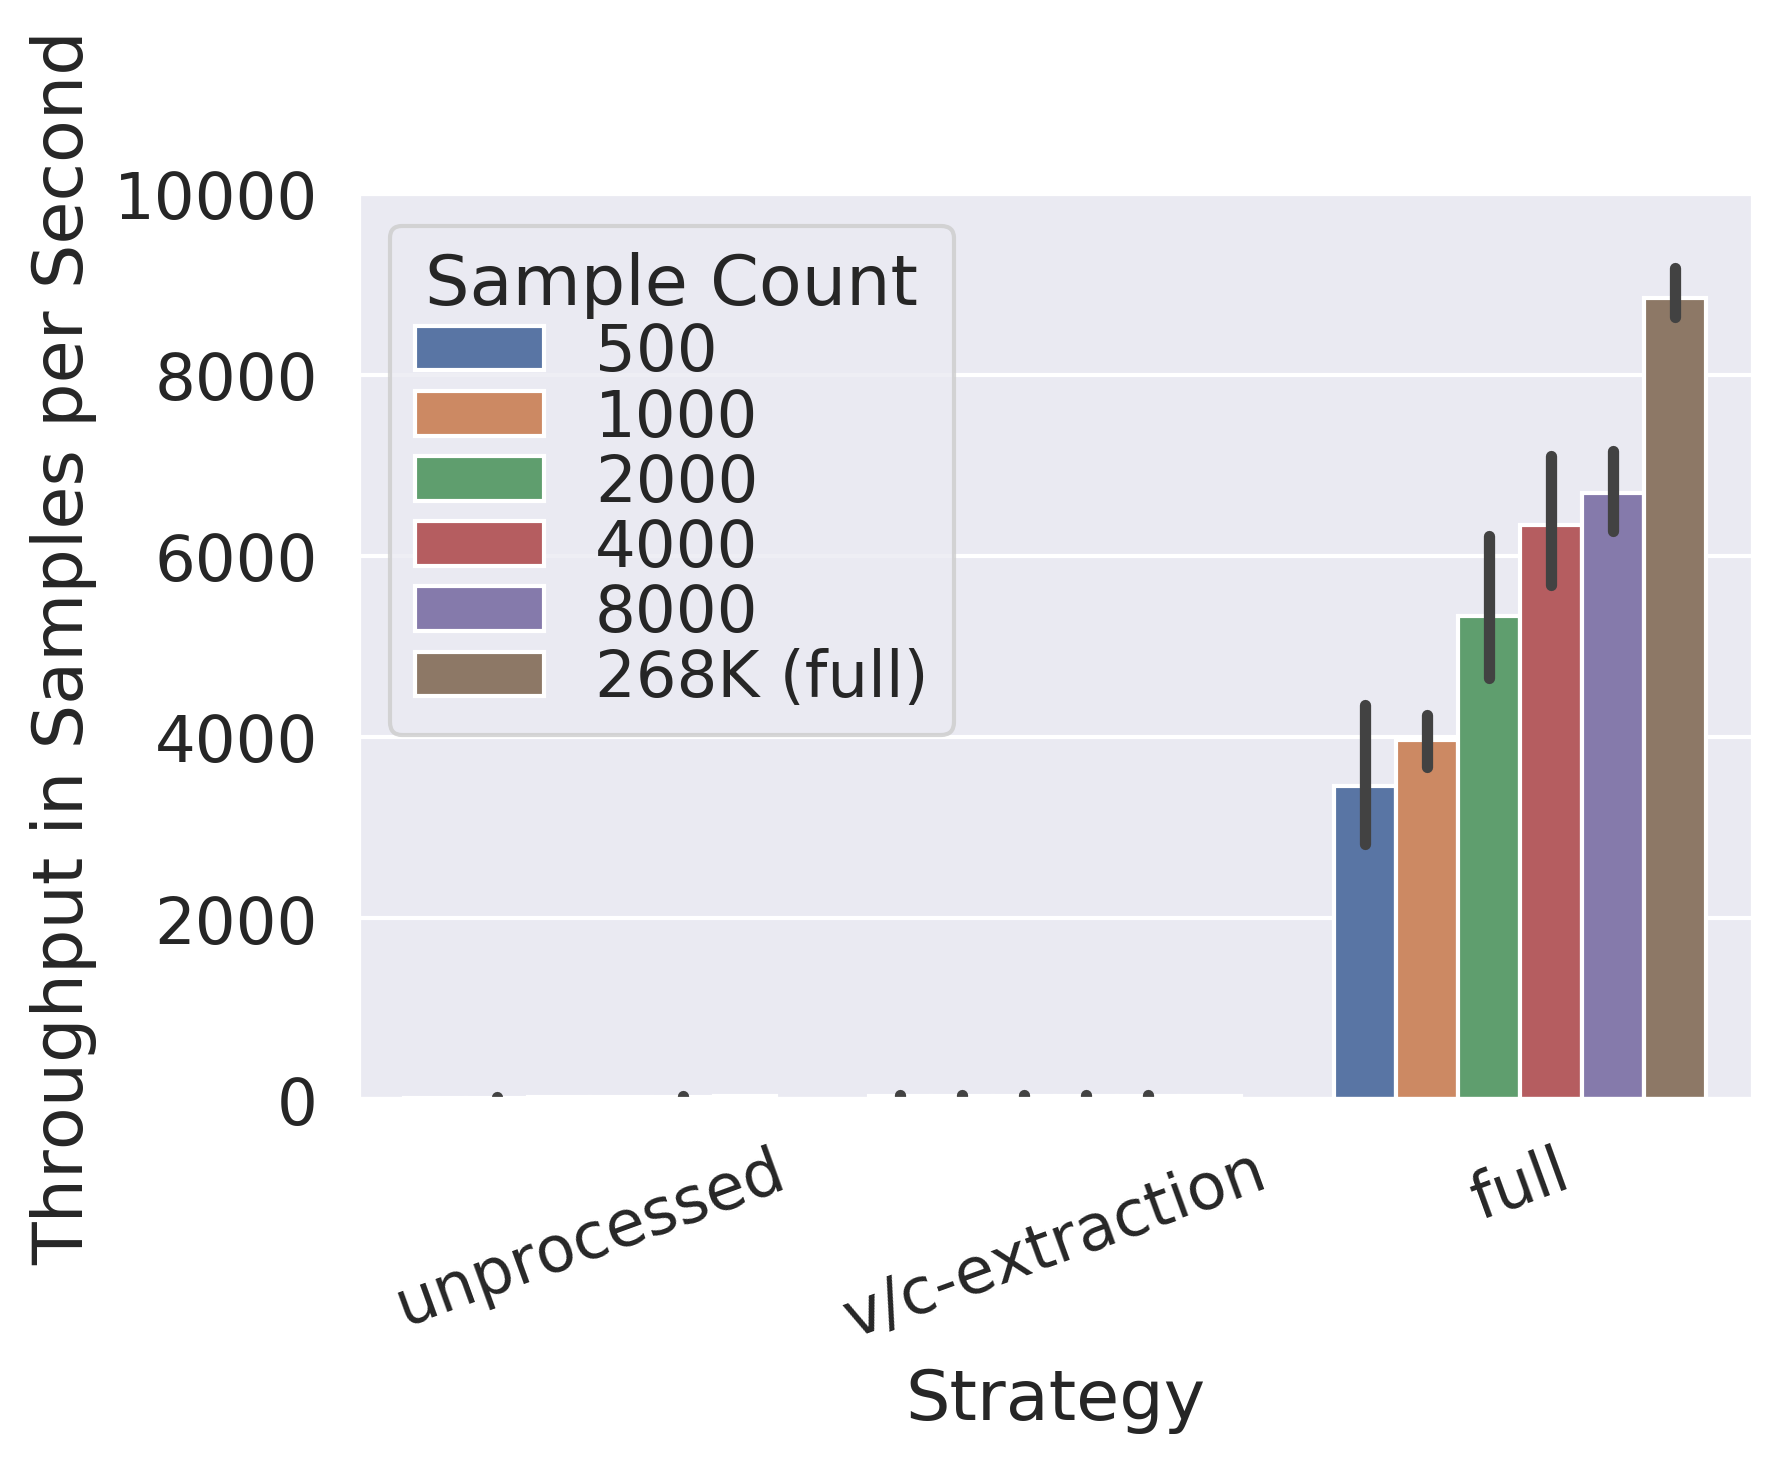

In [19]:
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Throughput per Strategy with 8 Threads\n {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Second")
plot.set(ylim=(0, 10000))
plot.legend(title="Sample Count", ncol=1,labelspacing=0.05)
save_fig("throughput")

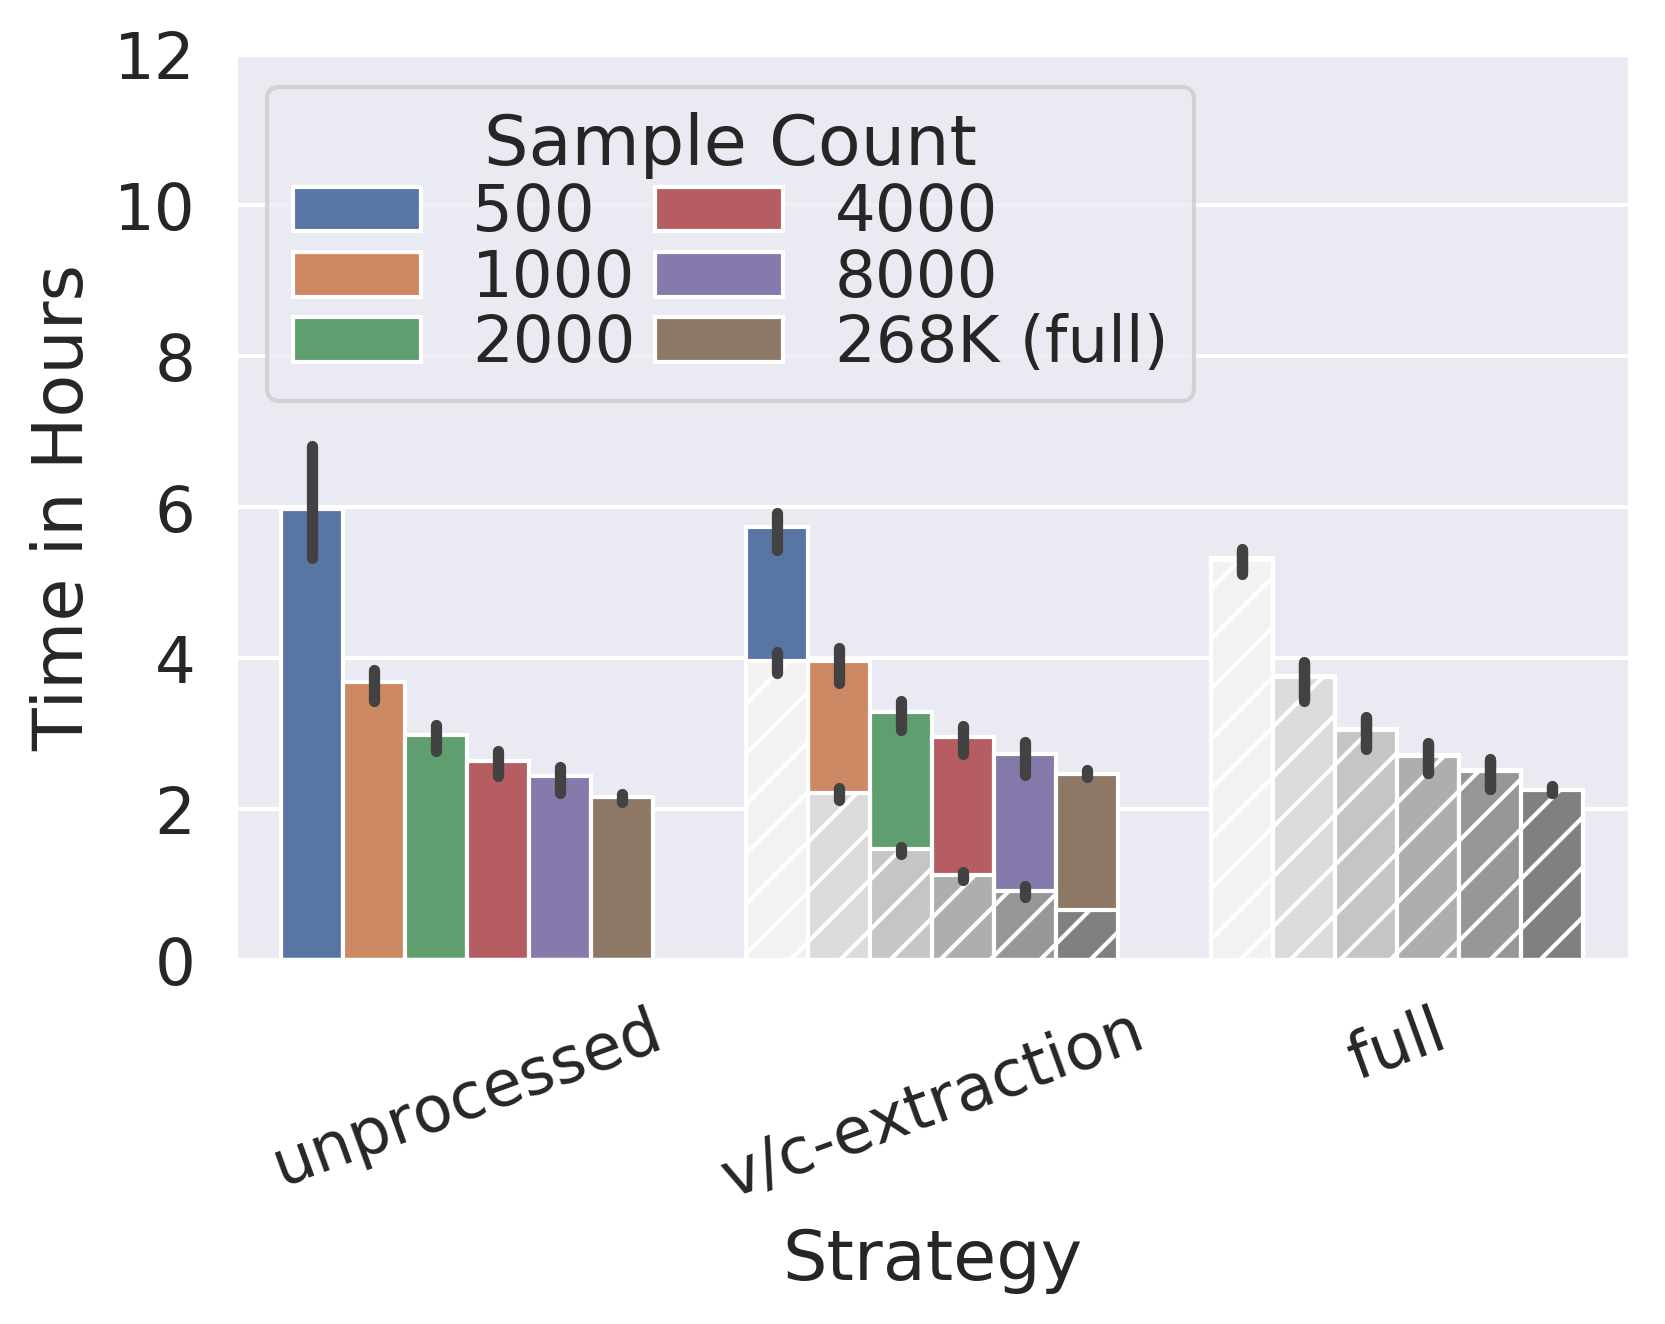

In [20]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8"),
    color="grey"
)

sample_counts = len([500, 1000, 2000, 4000, 8000, '268K (full)']) 
bars_to_skip = sample_counts * len(strategies)
hatches = ['//'] * bars_to_skip
for i,bar in enumerate(plot.patches[bars_to_skip:]):
    bar.set_hatch(hatches[i])

#plot.set_title(f"Per Epoch Per Sample Processing Time\n for Each Strategy with 8 Threads{sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Hours")
plot.set(ylim=(0, 12))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper left", ncol=2, labelspacing=0.05, columnspacing=0.3)
save_fig("full-processing-time")

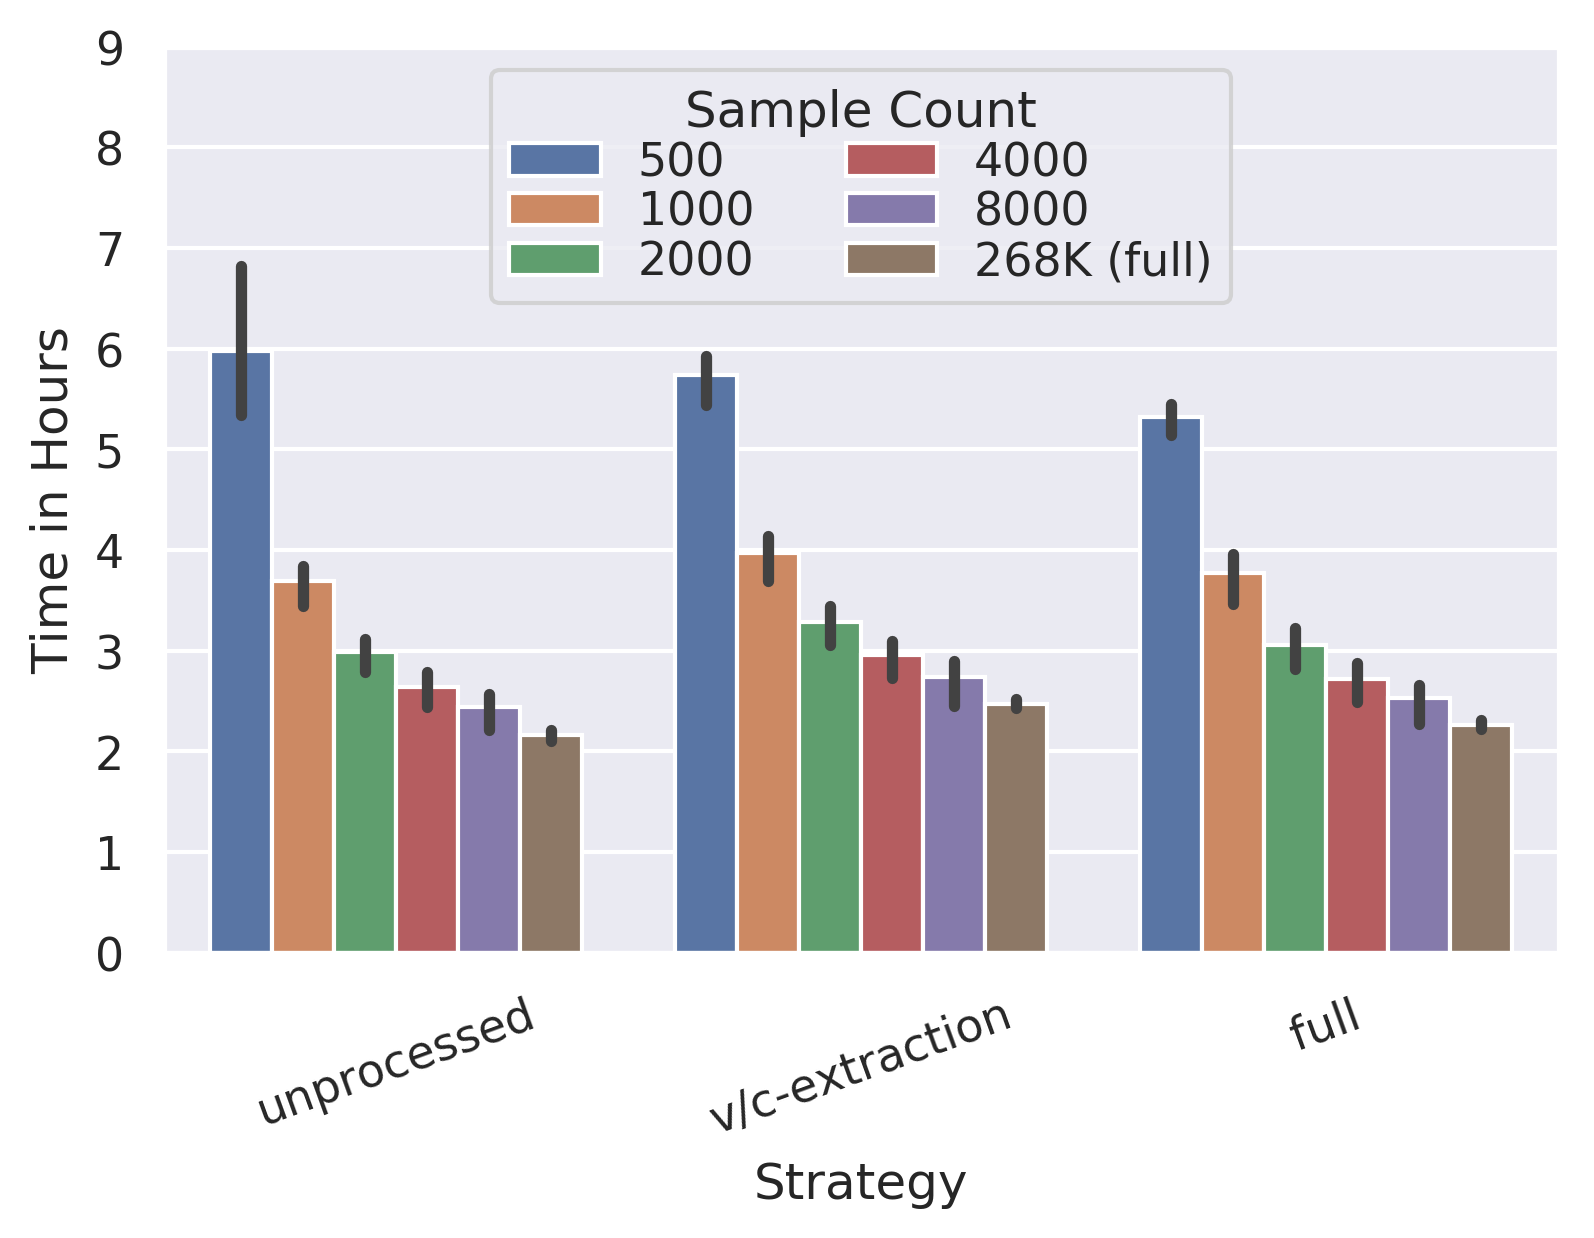

In [36]:
plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="sample_count",
    data=cum_df_mod.query(f"thread_count==8")
)
#plot.set_title(f"Extrapolated Full Dataset Processing Time\n for Each Strategy with 8 Threads {sampling_tag}")
plot.set_xticklabels(
    strategies_renamed
  , rotation=20
)
plot.set(xlabel="Strategy", ylabel="Time in Hours")
plot.set(ylim=(0, 9))
plot.legend(title="Sample Count", loc="upper center", ncol=2,labelspacing=0.10)
#save_fig("full-processing-time")

# Warning - Creating the plots based on `dstat` logs can take several hours

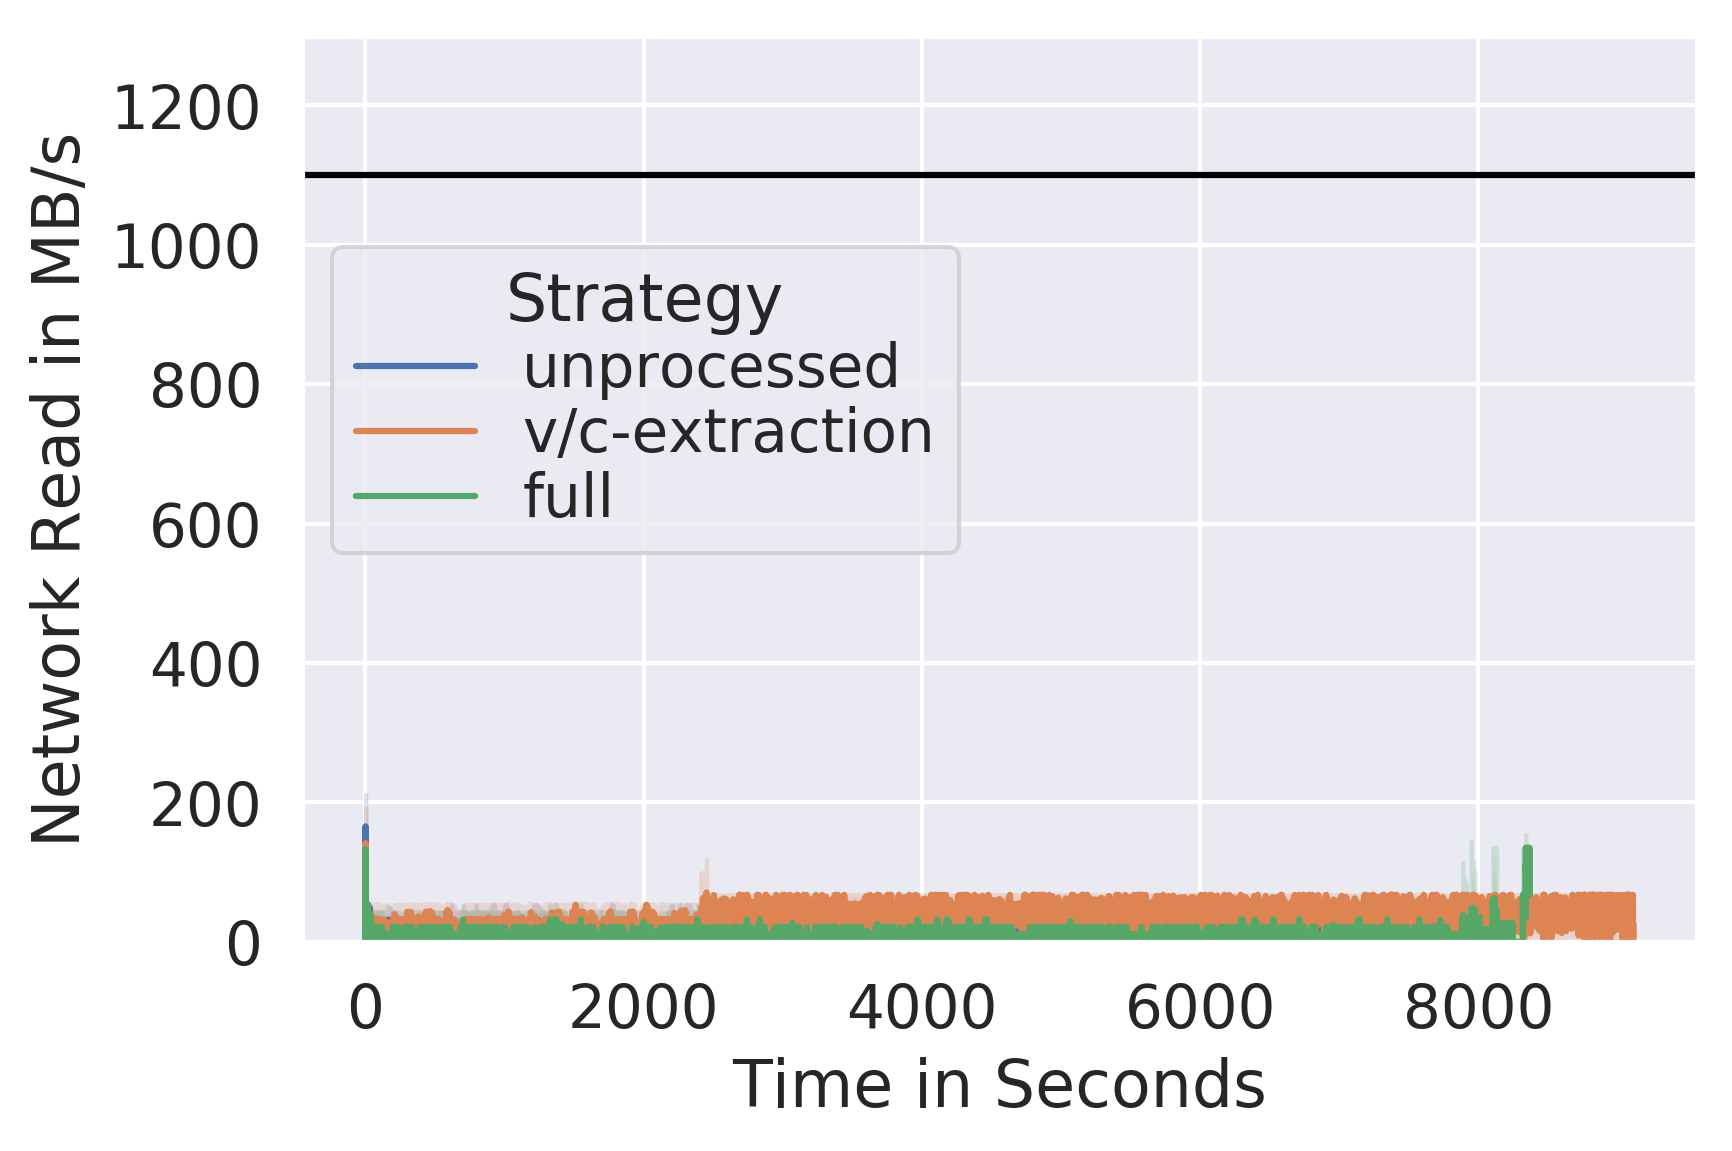

In [22]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_windowcount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1300))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper left", bbox_to_anchor=(0,0.8), ncol=1,labelspacing=0.10)
save_fig("network-read-speed-t8-full", file_type="png")

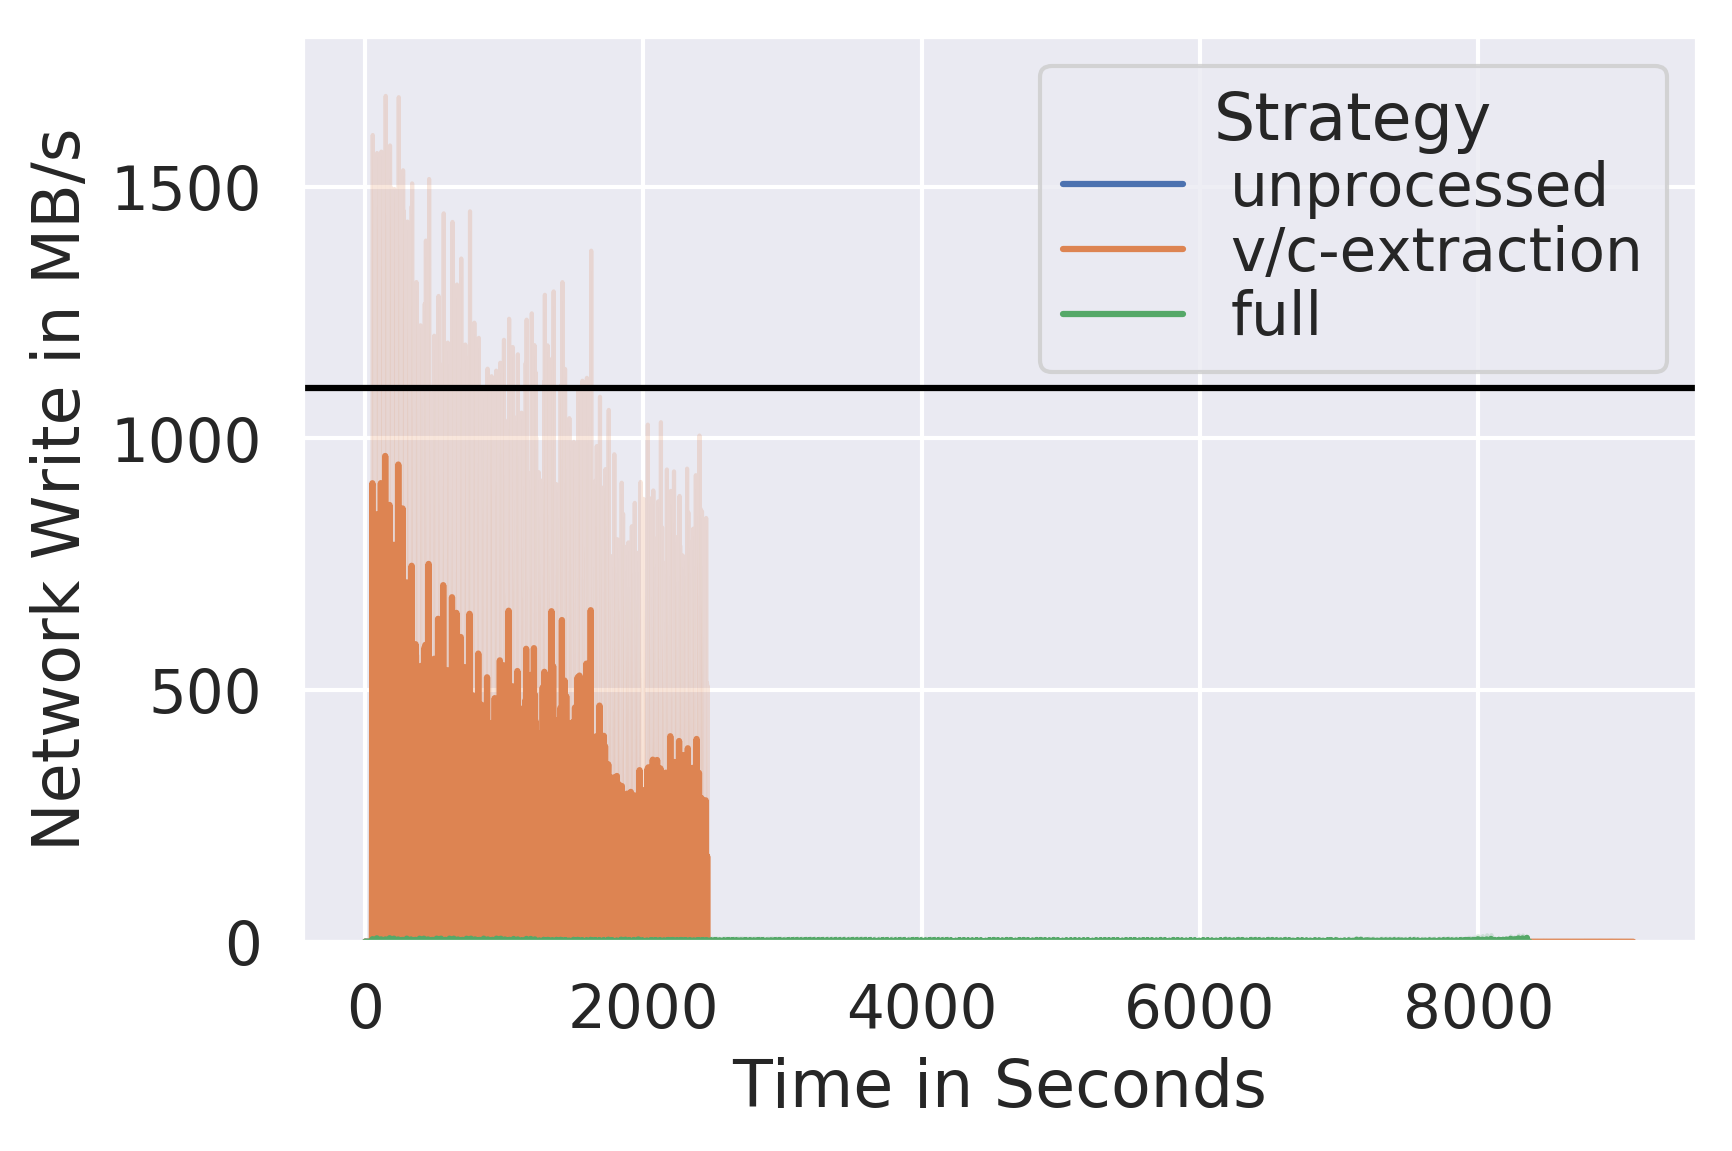

In [23]:
sns.set(font_scale=1.3)
test_df = cum_dstat_df.query(f"sample_count=={full_dataset_windowcount}").copy(deep=True)
test_df["sample_count"] = test_df.sample_count.astype('category')
test_df["split_name"] = test_df.split_name.astype('category')
test_df["thread_count"] = test_df.thread_count.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="net_write_mbs",
    hue="split_name",
    data=test_df.query("thread_count==8"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Write in MB/s")
plot.set(ylim=(0, 1800))
plot.axhline(1100, color="black")
plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
save_fig("network-write-speed-t8-full", file_type="png")